### **Optimization of Global ICT Market Selection**

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

### Import Data

In [745]:
AtE = pd.read_excel('Access to electricity (percentage of population).xls')
ANNI = pd.read_excel('Adjusted net national income (annual % growth).xls')
CPIA_EM = pd.read_excel('CPIA economic management cluster average.xls')
CPIA_SP = pd.read_excel('CPIA structural policies cluster average.xls') 
GDP_GR = pd.read_excel('GDP growth (annual %).xls')
GDPPC_GR = pd.read_excel('GDP per capita growth (annual %).xls')
ICTG_I = pd.read_excel('ICT goods imports (% total goods imports).xls')
IuI = pd.read_excel('Individuals using the Internet (% of population).xls')
LPI = pd.read_excel('Logistics performance index.xls')
REC = pd.read_excel('Renewable energy consumption (% of total final energy consumption).xls')
IG = pd.read_excel('Income group.xls')

### Data preparation

#### Handle missing values according to Income Group

In [ ]:
IG['Income Group'].unique()

In [746]:
IG_dict = dict(zip(IG['Country Code'], IG['Income Group']))

In [747]:
def Fill_NaN(data, columns):
    data['Income Group'] = data['Country Code'].map(IG_dict)
    for c in columns:
        group_means = data.groupby('Income Group')[c].transform('mean')
        data[c] = data[c].fillna(group_means)

In [748]:
Fill_NaN(AtE, ['AtE 2021'])
Fill_NaN(ANNI, ['ANNI 2021'])
Fill_NaN(CPIA_EM, ['CPIA EM 2022'])
Fill_NaN(CPIA_SP, ['CPIA SP 2022'])
Fill_NaN(GDP_GR, ['GDP growth rate 2018', 'GDP growth rate 2019', 'GDP growth rate 2020', 'GDP growth rate 2021', 'GDP growth rate 2022'])
Fill_NaN(GDPPC_GR, ['GDPPC GR 2018', 'GDPPC GR 2019', 'GDPPC GR 2020', 'GDPPC GR 2021', 'GDPPC GR 2022'])
Fill_NaN(ICTG_I, ['ICT goods imports 2017', 'ICT goods imports 2018', 'ICT goods imports 2019', 'ICT goods imports 2020', 'ICT goods imports 2021'])
Fill_NaN(IuI, ['II 2017', 'II 2018', 'II 2019', 'II 2020', 'II 2021'])
Fill_NaN(LPI, ['LPI 2022'])
Fill_NaN(REC, ['REC 2020'])

#### Merge Datasets

In [749]:
df_list = [AtE, ANNI, CPIA_EM, CPIA_SP, GDP_GR, GDPPC_GR, ICTG_I, IuI, LPI, REC]

df_merged = df_list[0]
for t in df_list[1:]:
    df_merged = pd.merge(df_merged, t, how = 'inner', on = ['Country Name', 'Country Code', 'Income Group'])

#### Drop rows with most missing values

In [750]:
df_merged = df_merged.drop([110, 254], index = None)

#### Add columns representing mean and their standardized values  

In [751]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_merged['AtE_s 2021'] = scaler.fit_transform(df_merged[['AtE 2021']])
df_merged['ANNI_s 2021'] = scaler.fit_transform(df_merged[['ANNI 2021']])
df_merged['CPIA_EM_s 2022'] = scaler.fit_transform(df_merged[['CPIA EM 2022']])
df_merged['CPIA_SP_s 2022'] = scaler.fit_transform(df_merged[['CPIA SP 2022']])

df_merged['GDPGR_avg'] = df_merged[df_merged['Country Code'] != 'WLD'].loc[:, 'GDP growth rate 2018':'GDP growth rate 2022'].mean(axis = 1)
df_merged.loc[df_merged['Country Code'] == 'WLD', 'GDPGR_avg'] = df_merged.loc[df_merged['Country Code'] == 'WLD', 'GDP growth rate 2018':'GDP growth rate 2022'].mean(axis = 1)
df_merged['GDPGR_avg_s'] = scaler.fit_transform(df_merged[['GDPGR_avg']])

df_merged['GDPPC_GR_avg'] = df_merged[df_merged['Country Code'] != 'WLD'].loc[:, 'GDPPC GR 2018':'GDPPC GR 2022'].mean(axis = 1)
df_merged.loc[df_merged['Country Code'] == 'WLD', 'GDPPC_GR_avg'] = df_merged.loc[df_merged['Country Code'] == 'WLD', 'GDPPC GR 2018':'GDPPC GR 2022'].mean(axis = 1)
df_merged['GDPPC_GR_avg_s'] = scaler.fit_transform(df_merged[['GDPPC_GR_avg']])

df_merged['ICTG_I_avg'] = df_merged[df_merged['Country Code'] != 'WLD'].loc[:, 'ICT goods imports 2017':'ICT goods imports 2021'].mean(axis = 1)
df_merged.loc[df_merged['Country Code'] == 'WLD', 'ICTG_I_avg'] = df_merged.loc[df_merged['Country Code'] == 'WLD', 'ICT goods imports 2017':'ICT goods imports 2021'].mean(axis = 1)
df_merged['ICTG_I_avg_s'] = scaler.fit_transform(df_merged[['ICTG_I_avg']])

df_merged['II_avg'] = df_merged[df_merged['Country Code'] != 'WLD'].loc[:, 'II 2017':'II 2021'].mean(axis = 1)
df_merged.loc[df_merged['Country Code'] == 'WLD', 'II_avg'] = df_merged.loc[df_merged['Country Code'] == 'WLD', 'II 2017':'II 2021'].mean(axis = 1)
df_merged['II_avg_s'] = scaler.fit_transform(df_merged[['II_avg']])

df_merged['LPI_s 2022'] = scaler.fit_transform(df_merged[['LPI 2022']])
df_merged['REC_s 2020'] = scaler.fit_transform(df_merged[['REC 2020']])

df_merged['market_score'] = df_merged[['AtE_s 2021', 'ANNI_s 2021', 'CPIA_EM_s 2022', 'CPIA_SP_s 2022', 'GDPGR_avg_s',
                  'GDPPC_GR_avg_s', 'ICTG_I_avg_s', 'II_avg_s', 'LPI_s 2022', 'REC_s 2020']].sum(axis = 1)

#### Split merged into 'df_merged' and 'df_world'

In [752]:
df_world = df_merged[df_merged['Country Code'] == 'WLD']
df_merged = df_merged.drop(df_merged[df_merged['Country Code'] == 'WLD'].index, index = None)

#### Drop rows of 'df_merged' with missing values in 'Income Group' 

In [753]:
df_merged = df_merged.drop(df_merged[df_merged['Income Group'].isnull()].index)
df_merged.reset_index(drop = True, inplace = True)
df_world.reset_index(drop = True, inplace = True)

### Construct the optimization model

#### Set up 'score_dict' for setting the objective function

In [754]:
df_merged_dict = df_merged.to_dict()

#### Set up 'country_name' for adding variables

In [755]:
country_name = df_merged['Country Name'].tolist()

#### Set up 'world_values' for adding constraints

In [756]:
df_world_dict = df_world.to_dict()

#### Set up model

In [1169]:
model = gp.Model('Global market selection')

num_country = len(df_merged['Country Code'])

country = model.addVars(num_country, vtype = GRB.BINARY, name = country_name)
w = model.addVars(10, vtype = GRB.CONTINUOUS, lb = 0, ub = 5)

model.setObjective(sum(country[i] * (w[0] * df_merged_dict['AtE_s 2021'][i] + 
                                     w[1] * df_merged_dict['ANNI_s 2021'][i] +
                                     w[2] * df_merged_dict['CPIA_EM_s 2022'][i] +
                                     w[3] * df_merged_dict['CPIA_SP_s 2022'][i] +
                                     w[4] * df_merged_dict['GDPGR_avg_s'][i] +
                                     w[5] * df_merged_dict['GDPPC_GR_avg_s'][i] +
                                     w[6] * df_merged_dict['ICTG_I_avg_s'][i] +
                                     w[7] * df_merged_dict['II_avg_s'][i] +
                                     w[8] * df_merged_dict['LPI_s 2022'][i] +
                                     w[9] * df_merged_dict['REC_s 2020'][i])
                                     for i in range(num_country)), GRB.MAXIMIZE)

model.addConstr(sum(country[i] for i in range(num_country)) <= 3)

for i in [0, 2, 3, 6, 7, 8, 9]:
    model.addConstr(w[i] == 1)
for i in [1, 4, 5]:
    model.addConstr(w[i] == 2.5)

for c in range(num_country):
    model.addConstr(df_merged_dict['LPI 2022'][c] >= country[c] * 2)
    model.addConstr(df_merged_dict['CPIA EM 2022'][c] >= country[c] * 3)
    model.addConstr(df_merged_dict['CPIA SP 2022'][c] >= country[c] * 3)
    model.addConstr(df_merged_dict['GDPGR_avg'][c] * country[c] >= 0)
    model.addConstr(df_merged_dict['GDPPC_GR_avg'][c] * country[c] >= 0)
    
    model.addConstr(df_merged_dict['REC_s 2020'][c] >= country[c] * df_world_dict['REC_s 2020'][0])
    model.addConstr((df_merged_dict['ANNI_s 2021'][c] >= country[c] * df_world_dict['ANNI_s 2021'][0]))

    model.addConstr(df_merged_dict['AtE_s 2021'][c] >= country[c] * 0.5)
    model.addConstr(df_merged_dict['II_avg_s'][c] >= country[c] * 0.5)
    model.addConstr(df_merged_dict['ICTG_I_avg'][c] >= country[c] * 0.5)


model.optimize()

label = []

for c in model.getVars():
    if c.x == 1:
        print(f'{c.VarName} = {c.x}')
        label.append(c.VarName)
        print(df_merged[df_merged['Country Name'] == c.VarName]['market_score'])
print(f'Obj is {model.ObjVal}')

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2171 rows, 226 columns and 2386 nonzeros
Model fingerprint: 0xa2613268
Model has 2148 quadratic objective terms
Variable types: 10 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-04, 2e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e-04, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 2170 rows and 203 columns
Presolve time: 0.01s
Presolved: 1 rows, 23 columns, 23 nonzeros
Variable types: 0 continuous, 23 integer (23 binary)
Found heuristic solution: objective 24.8361657

Root relaxation: objective 2.496279e+01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node

### Visualize the result

In [900]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1171]:
df_selected_markets = df_merged[df_merged['Country Name'].isin(label)][['Country Name', 'market_score', 'AtE_s 2021', 'ANNI_s 2021', 'CPIA_EM_s 2022', 'CPIA_SP_s 2022', 
                                                                        'GDPGR_avg_s', 'GDPPC_GR_avg_s', 'ICTG_I_avg_s', 'II_avg_s', 'LPI_s 2022', 'REC_s 2020']]

market_score


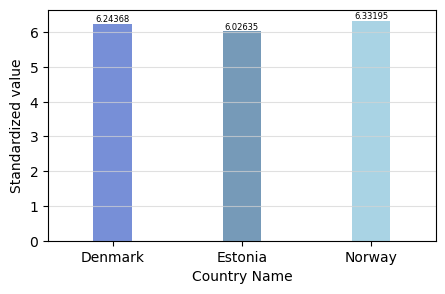

AtE_s 2021


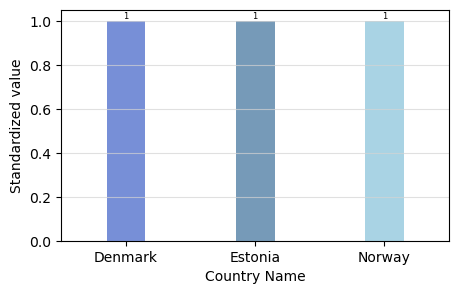

ANNI_s 2021


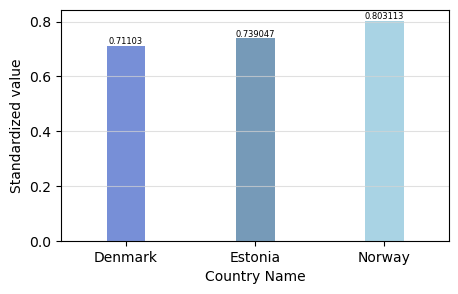

CPIA_EM_s 2022


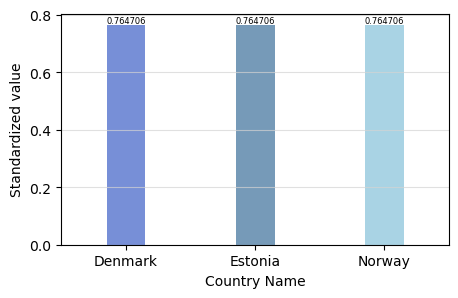

CPIA_SP_s 2022


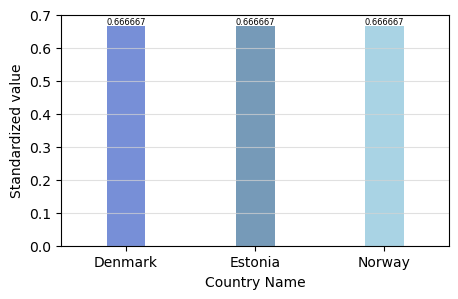

GDPGR_avg_s


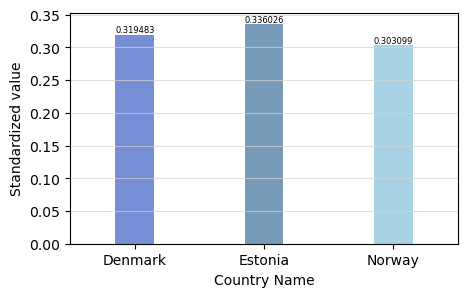

GDPPC_GR_avg_s


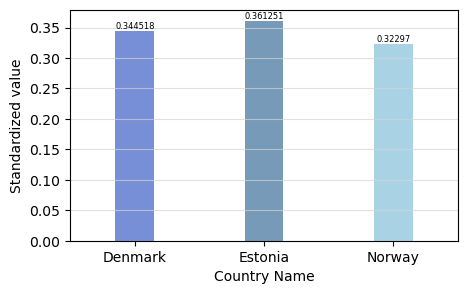

ICTG_I_avg_s


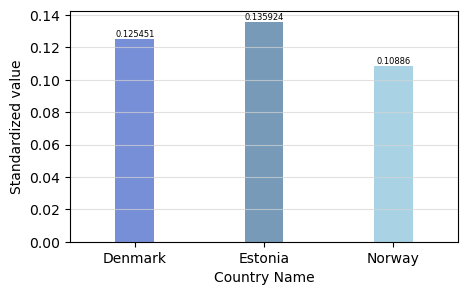

II_avg_s


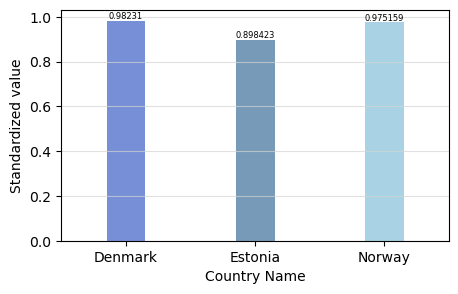

LPI_s 2022


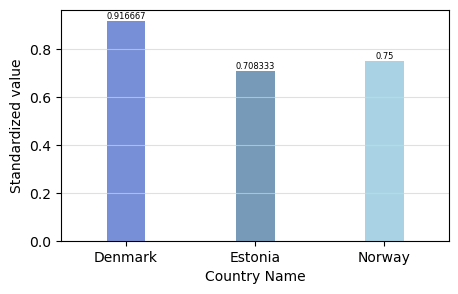

REC_s 2020


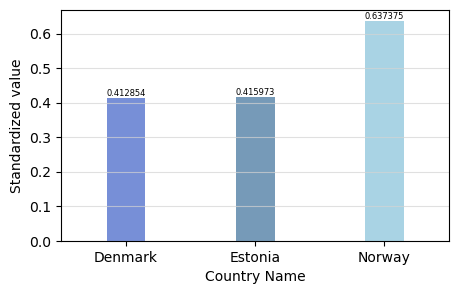

In [1172]:
for column in df_selected_markets.columns[1:]:
    print(column)
    plt.figure(figsize = (5, 3))
    plt.grid(color = 'lightgray', axis = 'y', alpha = 0.7)
    ax = sns.barplot(data = df_selected_markets, y = column, x = 'Country Name', palette = ['royalblue', 'steelblue', 'skyblue'], alpha = 0.8, width = 0.3)
    ax.bar_label(container = ax.containers[0], fontsize = 6)
    plt.xlabel('Country Name')
    plt.ylabel('Standardized value')
    plt.show()